<div style="text-align: center; font-size:x-large;">기계학습 과제 1</div>

<div style="text-align: center; font-size:large;">2024. 9</div>

### 개요

<div style="margin-left:10px">&nbsp; python의 sklearn 모듈와 statsmodels을 이용하여 데이터를 분석하고, 시각화가 필요한 경우에는 plotly를 이용하였다. 사용할 패키지와 데이터 불러오기 등 분석에 필요한 사전 작업을 아래에 기술하였다. 분석에 필요한 $\text{College}$ 데이터의 경우 이름이 지어지지 않은 첫 번째 열은 유일성을 지니는 대학 이름이므로, 설명변수에 적합하지 않다고 판단하여 제거하였다. 또한, 두 개의 범주를 가진 Private 열의 경우, statsmodels에서 모형을 적합시키기 위해 Yes를 1로 하는 정수형 자료로 재표현하여 분석하였다. </div>

In [291]:
## basic modules
import pandas as pd
import numpy as np
import itertools
import scipy.stats
import warnings

## model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

## Visualization
import plotly.io as pio
import plotly.express as px

## plotly backend
pd.options.plotting.backend = 'plotly'
pio.templates.default = 'plotly_white'

## Data preprocessing
College = pd.read_csv("/root/ML2024/data/Data/College.csv", index_col=0)\
.reset_index(drop = True).assign(Private = lambda _df : _df.Private.map(lambda x : 1 if x == "Yes" else 0))

## ignore warnings
warnings.filterwarnings('ignore')

### 문제

#### 1. 데이터 $\text{Colleage}$를 찾아서 다음을 수행하시오.(아래 각 문항 당 1.25점)

---

<div style="margin-left:30px;text-indent:-20px">(a) $\text{Grad.rate}$를 반응변수로 범주형을 제외한 나머지 변수들을 설명변수로 하여 선형회귀분석을 시행하고 그 분산분석표를 보여주시오.</div>

&nbsp; `Grad.Rate`를 반응변수 데이터프레임 `y`, 범주형 변수 `Private`와 반응변수열을 제외한 설명변수 데이터프레임 `X`를 생성하고, 선형회귀모형을 구성하였다. 이후, 분산분석표를 산출하기 위해 평균만 있는 모형을 구성하고 부분 F-검정을 하는 방식으로 선형회귀모형의 분산분석표를 얻어낼 수 있었다.

In [132]:
## Features and Target generating
y = College["Grad.Rate"]
X = pd.concat([pd.DataFrame({'intercept' : np.ones(College.shape[0])}),College.drop(["Grad.Rate", "Private"], axis = 1)], axis = 1)

## Linear Regression Model Fitting
model = sm.OLS(y, X)
results = model.fit()

## Generating Null Model & print ANOVA table
model_null = sm.OLS(y, pd.DataFrame({'intercept' : np.ones(College.shape[0])}))
results_null = model_null.fit()
print(anova_lm(results_null, results))

   df_resid            ssr  df_diff        ss_diff         F        Pr(>F)
0     776.0  228977.204633      0.0            NaN       NaN           NaN
1     760.0  123940.260794     16.0  105036.943839  40.25532  5.343712e-90


---

<div style="margin-left:30px;text-indent:-20px">(b) 위의 결과 중 유의한(유의확률 $0.05$) 변수들을 나열하시오.</div>

`-` 회귀계수 표

In [121]:
print(results.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      37.0418      4.589      8.072      0.000      28.033      46.051
Apps            0.0012      0.000      2.710      0.007       0.000       0.002
Accept         -0.0006      0.001     -0.644      0.520      -0.002       0.001
Enroll          0.0021      0.002      0.923      0.356      -0.002       0.007
Top10perc       0.0626      0.072      0.872      0.384      -0.078       0.204
Top25perc       0.1352      0.055      2.454      0.014       0.027       0.243
F.Undergrad    -0.0006      0.000     -1.438      0.151      -0.001       0.000
P.Undergrad    -0.0015      0.000     -3.901      0.000      -0.002      -0.001
Outstate        0.0012      0.000      5.307      0.000       0.001       0.002
Room.Board      0.0020      0.001      3.485      0.001       0.001       0.003
Books          -0.0020      0.003     -0

> &nbsp; 회귀계수 표에서 기재된 순서대로 `Apps`, `Top25perc`, `P.Undergrad`, `Outstate`, `Room.Board`, `Personal`, `perc.alumni`, `Expend`의 총 $8$개 설명변수가 유의수준 $\alpha = 0.05$에서 통계적으로 유의했다.

---

<div style="margin-left:30px;text-indent:-20px">(c) $\hat y_i$를 구해서 이를 이용해 $R^2$를 계산하고, 모형에 대한 유의성 검정 결과를 서술하시오.</div>

&nbsp; 모형에서 적합된 값을 이용해 결정계수를 계산하고, 유의성을 검정하였다. 산출할 값들은 모두 소수점 4자리까지 반올림하여 출력하였다.

In [122]:
## yhat 구하기
train_fitted = results.get_prediction(X)
yhat = train_fitted.predicted_mean

## R-squares 값 계산하기
RSS = np.sum((y - yhat)**2)
TSS = np.sum((y - np.mean(y))**2)
R_sq = 1-RSS/TSS

print(f"R-squares = {R_sq:.4f}")

## 모형에 대한 유의성 검정(F-test)
p = X.shape[1]-1 ## except intercept column
n = X.shape[0]
F = ((TSS-RSS)/p)/(RSS/(n-p-1))
f_dist = scipy.stats.f(p, n-p-1)
print(f"\n임계값 c = {f_dist.ppf(0.95):.4f}")
print(f"F-value = {F:.4f}")
print(f"Pr(>F) = {1-f_dist.cdf(F):.4f}")

R-squares = 0.4587

임계값 c = 1.6568
F-value = 40.2553
Pr(>F) = 0.0000


&nbsp; $R^2$의 값은 $0.4587$였고, 이후 해당 모형에 대한 유의성을 F-test를 이용하여 검정하였다.

`-` 가설 설정 $$H_0 : \beta_1 = \beta_2 = \cdots = \beta_{16} ~ vs. ~ H_1 : ￢ ~ H_0$$

`-` 검정통계량 $$F = \frac{(TSS - RSS)/16}{RSS/(759)} \underset{H_0}{\sim} F(16, 759)$$

`-` 검정 결과

> &nbsp; 검정통계량의 관측치는 $40.2553$였고, 해당 관측치의 p-value가 충분히 작아$(p < 0.001)$ 해당 모형은 유의수준 $\alpha = 0.05$에서 통계적으로 유의함을 알 수 있었다.

---

<div style="margin-left:30px;text-indent:-20px">(d) 잔차도를 그리되 가로축은 예측값, 세로축은 잔차로 해서 그리시오.</div>

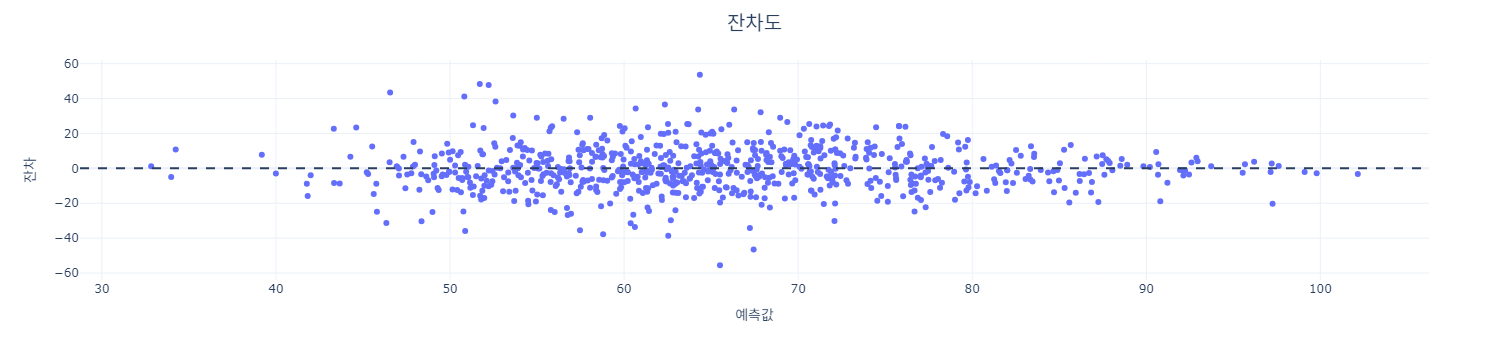

In [125]:
## 잔차값
ehat = y - yhat

## 잔차도
tidy = pd.DataFrame({"yhat" : yhat, "ehat" : ehat})
fig = tidy.plot.scatter(x = 'yhat', y = 'ehat')
fig.add_hline(0, line_dash = "dash")
fig.update_layout(
    title = "잔차도", title_x = 0.5, title_font_size = 20,
    xaxis_title="예측값",
    yaxis_title="잔차"
)
fig.show()

> &nbsp; 잔차도의 모양이 0을 중심으로 대칭이고, 이분산성 또한 육안으로 확인되지 않았다. 독립성이나 정규성은 알 수 없으나, 전체적으로 해당 모형은 회귀모형의 기본 가정을 위배하지 않을 것이라 기대할 수 있다.

---

<div style="margin-left:30px;text-indent:-20px">(e) 데이터를 두 개로 쪼개되 랜덤하게 쪼개지 않고 위로부터 $500$개 까지의 데이터와 $501$번째부터 끝까지의 데이터로 훈련 데이터 및 평가 데이터를 만들어 앞의 $10$개씩 출력해서 보여주시오.</div>

&nbsp; 범주형 변수 `Private`를 제외한 뒤, 훈련 데이터와 평가 데이터를 각각 `df_train`, `df_test`로 할당한 후, 순서대로 출력하였다.

In [128]:
## data selection
df_train = College.drop("Private", axis = 1).iloc[:500]
df_test = College.drop("Private", axis = 1).iloc[500:]

## display
display(df_train.head(10), "train data")
display(df_test.head(10), "test data")

Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  P.Undergrad  \
0  1660    1232     721         23         52         2885          537   
1  2186    1924     512         16         29         2683         1227   
2  1428    1097     336         22         50         1036           99   
3   417     349     137         60         89          510           63   
4   193     146      55         16         44          249          869   
5   587     479     158         38         62          678           41   
6   353     340     103         17         45          416          230   
7  1899    1720     489         37         68         1594           32   
8  1038     839     227         30         63          973          306   
9   582     498     172         21         44          799           78   

   Outstate  Room.Board  Books  Personal  PhD  Terminal  S.F.Ratio  \
0      7440        3300    450      2200   70        78       18.1   
1     12280        6450    750      1500   29        30       12.2   
2     11250        3750    400      1165   53        66       12.9   
3     12960        5450    450       875   92        97        7.7   
4      7560        4120    800      1500   76        72       11.9   
5     13500        3335    500       675   67        73        9.4   
6     13290        5720    500      1500   90        93       11.5   
7     13868        4826    450       850   89       100       13.7   
8     15595        4400    300       500   79        84       11.3   
9     10468        3380    660      1800   40        41       11.5   

   perc.alumni  Expend  Grad.Rate  
0           12    7041         60  
1           16   10527         56  
2           30    8735         54  
3           37   19016         59  
4            2   10922         15  
5           11    9727         55  
6           26    8861         63  
7           37   11487         73  
8           23   11644         80  
9           15    8991         52

'train data'

Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  P.Undergrad  \
500   150     130      88         23         50          341          768   
501  1910    1380     463         16         64         1715          106   
502  2248    1673     745         38         73         2888          105   
503  1606    1413     530         23         38         1921         1154   
504   700     595     278         19         35         1035          182   
505   785     647     295         15         65         1670          726   
506   489     384     120         23         52          700           45   
507   335     284     132         28         69          534          216   
508  4216    2290     736         20         52         4296         1027   
509  1680    1395     691         34         76         2959          402   

     Outstate  Room.Board  Books  Personal  PhD  Terminal  S.F.Ratio  \
500     10300        4130    500      1700   44        58       10.2   
501     13030        5860    500       750   79        88       14.5   
502     14350        3750    550       550   82        88       10.0   
503      9408        5520    500       450   78        78       12.1   
504     10850        3936    500       900   62        64       12.3   
505     10860        4624    600       794   87       100       13.7   
506     10575        3952    400       620   46        24       13.0   
507     10475        6300    500      2000   68        68       11.2   
508      5130        4690    600      1450   73        75       17.9   
509      8236        3700    569      1650   74        75       14.7   

     perc.alumni  Expend  Grad.Rate  
500           37    9678         75  
501           34   10190         84  
502           31   12502         83  
503           22    7669         53  
504           31    8534         88  
505           15    8953         55  
506            9    8946         98  
507           46    9599         60  
508           18    5125         56  
509           17    9533         61

'test data'

---

<div style="margin-left:30px;text-indent:-20px">(f) 훈련 데이터를 이용해서 회귀계수를 추정하고 이로부터 평가 데이터에서의 $\hat y_i$들을 히스토그램으로 보여주시오.</div>

&nbsp; 문제에 제시된 조건에 맞는 반응변수와 설명변수 데이터프레임을 각각 생성하고, 선형회귀모형을 구성하였다. 회귀계수 추정치와 평가 데이터 예측값의 히스토그램을 순서대로 산출하였다.

       Features  Coefficients
0     Intercept     27.241785
1          Apps      0.001264
2        Accept     -0.001100
3        Enroll      0.004348
4     Top10perc     -0.005245
5     Top25perc      0.220197
6   F.Undergrad     -0.000957
7   P.Undergrad     -0.001481
8      Outstate      0.001052
9    Room.Board      0.003287
10        Books     -0.002258
11     Personal     -0.000095
12          PhD      0.029264
13     Terminal     -0.014755
14    S.F.Ratio      0.068092
15  perc.alumni      0.286109
16       Expend     -0.000652




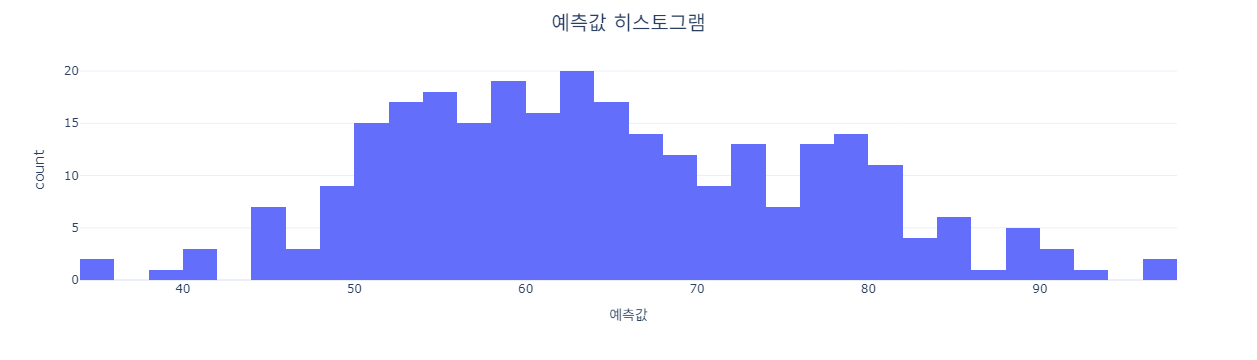

In [139]:
## train dataset : (y, X)
y = df_train["Grad.Rate"]
X = df_train.drop("Grad.Rate", axis = 1)

## test dataset : (yy, XX)
yy = df_test["Grad.Rate"]
XX = df_test.drop("Grad.Rate", axis = 1)

## modeling
predictr = LinearRegression()
predictr.fit(X, y)
yhat = predictr.predict(X) ## train data에서의 적합값
yyhat = predictr.predict(XX) ## test data에서의 예측값

## output coefficient
print(pd.DataFrame({'Features' : ["Intercept"]+list(X.columns), 'Coefficients' : [predictr.intercept_] + list(predictr.coef_)}))
print("\n")

## histogram
fig = px.histogram(yyhat, nbins = 40)
fig.update_layout(
    title = "예측값 히스토그램", title_x = 0.5, title_font_size = 20,
    xaxis_title="예측값",
    showlegend = False
)
fig.show()

---

<div style="margin-left:30px;text-indent:-20px">(g) 위에서 계산한 값을 이용해서 평가 데이터에서 $R^2$를 계산하고, 훈련 데이터에서의 $R^2$와 비교하시오.</div>

&nbsp; 구성된 모형을 이용하여 각 데이터에서의 $R^2$를 계산하고, 그 값을 소수점 4자리까지 반올림하여 출력하였다.

In [140]:
## 훈련 데이터에서의 R-squared
RSS_train = np.sum((y - yhat)**2)
TSS_train = np.sum((y - np.mean(y))**2)
R_sq_train = 1-RSS_train/TSS_train

print(f"훈련 데이터에서의 R-squares = {R_sq_train:.4f}")

## 평가 데이터에서 계산한 R-squared
RSS_test = np.sum((yy - yyhat)**2)
TSS_test = np.sum((yy - np.mean(yy))**2)
R_sq_test = 1-RSS_test/TSS_test

print(f"평가 데이터에서의 R-squares = {R_sq_test:.4f}")

훈련 데이터에서의 R-squares = 0.4387
평가 데이터에서의 R-squares = 0.4587


> &nbsp; 평가 데이터에서의 $R^2$값이 훈련 데이터에서의 $R^2$보다 더 컸지만, 유사한 수준으로 나타났다. 이에 따라 모형은 과적합되지 않았다고 판단할 수 있다.

---

<div style="margin-left:30px;text-indent:-20px">(h) 훈련 데이터에서 얻은 회귀계수로 평가 데이터 $\underset{i=1}{\overset{n_{ts}}{\sum}}(y_i - \hat y_i)^2/n_{ts}$와 훈련 데이터 $\underset{i=1}{\overset{N_{tr}}{\sum}}(y_i - \hat y_i)^2/N_{tr}$를 계산하고 이 둘을 비교하시오.</div>

&nbsp; 훈련 데이터에서 얻은 모형으로 평가 데이터와 훈련 데이터에서의 모형 평가 지표를 소수점 3자리까지 반올림하여 산출하였다.

In [141]:
## Train MSE
print(f"훈련 데이터 지표 : {RSS_train/X.shape[0]:.3f}")

## Test MSE
print(f"평가 데이터 지표 : {RSS_test/XX.shape[0]:.3f}")

훈련 데이터 지표 : 165.026
평가 데이터 지표 : 159.088


> &nbsp; 평가 데이터에서의 MSE가 훈련 데이터보다 더 작았다. 모형은 과적합되지 않았으며, 평가 데이터에서의 MSE가 더 작은 것은 모형의 MSE가 높고, 평가 데이터의 수가 작기 때문에 발생할 수 있는 현상이다.

#### 2. 데이터 $\text{Colleage}$를 찾아서 다음을 수행하시오.

&nbsp; 해당 문제의 하위 문제들을 해결하기 위해 아래와 같은 함수를 먼저 선언하였다.

In [221]:
## Mallow's Cp 산출 함수
def calculate_mallows_cp(X, y, RSS, sigma_squared):
    n = len(y)
    p = X.shape[1]  # Number of Features for model
    Cp = RSS/sigma_squared - (n-2*p)
    return Cp

## 선택 변수 개수에 따른 모든 변수 조합 및 Mallow's Cp값 산출 함수
def Cp_Features_Combinations(X, y, p = None, s = None):
    """
    X : Features(pandas dataframe)
    y : Target(pandas series)
    p : 최대 선택 변수 개수
    s : 최소 선택 변수 개수
    """
    if p == None :
        p = X.shape[1]
    if s == None :
        s = 1
    
    n = len(y)
    n_features = X.shape[1]
    
    ## full model로 sigma squared 예측값 산출
    predictr = LinearRegression()
    predictr.fit(X, y)
    yhat = predictr.predict(X)
    sigma_squared = np.sum((y - yhat)**2)/(n-n_features-1)
    
    Cps = []
    Num_Features = []
    Combinations = []

    ## 선택 변수 개수에 따른 가능한 모든 조합 산출
    for k in range(s, p + 1):
        for subset in itertools.combinations(range(n_features), k):
            X_subset = X.iloc[:, list(subset)]
            model = LinearRegression()
            model.fit(X_subset, y)
            yhat_sub = model.predict(X_subset)
            RSS = np.sum((y - yhat_sub) ** 2)
            Cps.append(calculate_mallows_cp(X_subset, y, RSS, sigma_squared))
            Num_Features.append(k)
            Combinations.append(list(X.columns[list(subset)]))

    return Cps, Num_Features, Combinations

---

<div style="margin-left:30px;text-indent:-20px">(a) 모든 데이터를 훈련 데이터로 하여, $\text{Grad.rate}$를 반응변수로 하고 범주형을 제외한 나머지 변수들 중 하나의 변수만 예측변수로 한 경우들에 대해서 $\text{Mallow's} ~ C_p$를 구하시오. (3점)</div>

&nbsp; 범주형 설명변수 `Private`를 제외한 나머지 설명변수들로 각각 선형회귀모형을 구성한 뒤, 각 모형 별 $\text{Mallow's} ~ C_p$를 산출하였다.

In [227]:
Cps, Num_Features, Combinations = Cp_Features_Combinations(X, y, 1, 1)
df_cp = pd.DataFrame({"Features" : Combinations, "Cp" : Cps})
df_cp = df_cp.assign(Features = lambda _df : _df.Features.map(lambda x : x.pop()))
df_cp

Features          Cp
0          Apps  598.845458
1        Accept  622.723236
2        Enroll  628.384307
3     Top10perc  285.064125
4     Top25perc  309.238304
5   F.Undergrad  620.372479
6   P.Undergrad  536.345984
7      Outstate  170.830793
8    Room.Board  375.542006
9         Books  629.083536
10     Personal  527.224117
11          PhD  498.437678
12     Terminal  511.386253
13    S.F.Ratio  497.001043
14  perc.alumni  290.728100
15       Expend  415.148290

> &nbsp; 모형 별 $\text{Mallow's} ~ C_p$를 산출한 결과, `Outstate`만 설명변수로 사용한 모형의 $C_p$값이 가장 작기 때문에 해당 모형이 설명변수가 하나인 모형들 중 가장 좋은 모형이라고 말할 수 있다.

---

<div style="margin-left:30px;text-indent:-20px">(b) 위에서 고려한 예측 변수들의 조합에($\text{All Subset}$) 대해서 $\text{Mallow's} ~ C_p$를($\text{Grad.Rate}$는 반응변수) 구하고 변수들의 개수를 $x$축으로 하여 산점도를 그리시오. (3점)</div>

In [229]:
## 가능한 모든 조합(2**16-1) 산출
Cps, Num_Features, Combinations = Cp_Features_Combinations(X, y)

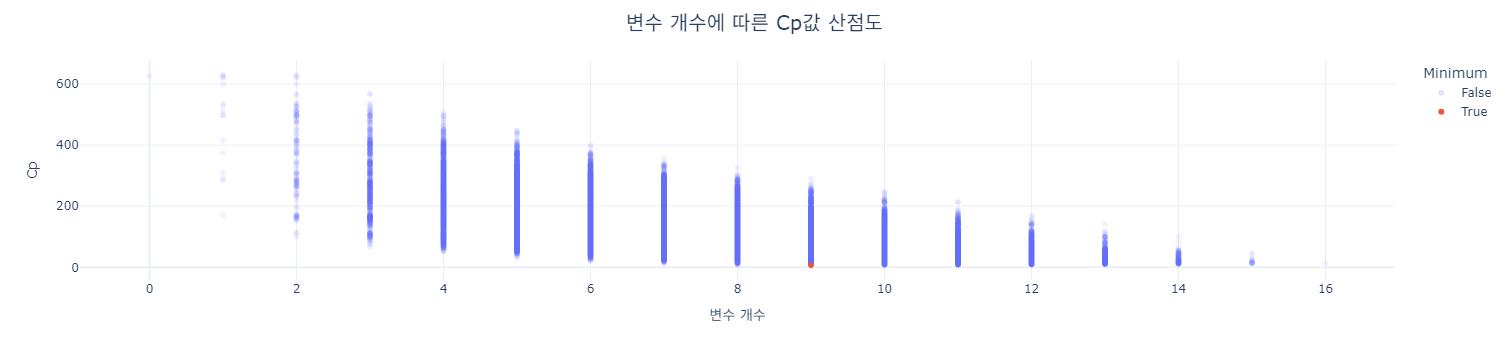


Mallow's Cp값이 최소가 되는 모형의 설명변수 : ['Apps', 'Top25perc', 'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Personal', 'perc.alumni', 'Expend']


In [299]:
## Null model Cp 추가(총 2**16개의 모형)
Null_RSS = np.sum((y - np.mean(y))**2)
Null_Cp = Null_RSS/sigma_sq - (len(y)-0*2)
tidy = pd.concat([pd.DataFrame({"Number of Features" : [0], "Cp" : [Null_Cp]}), pd.DataFrame({"Number of Features" : Num_Features, "Cp" : Cps})], axis = 0).assign(Minimum = tidy.Cp == min(Cps))
fig = tidy.plot.scatter(x = "Number of Features", y = "Cp", opacity = 0.1, color = "Minimum")
fig.update_layout(
    title = "변수 개수에 따른 Cp값 산점도", title_x = 0.5, title_font_size = 20,
    xaxis_title="변수 개수"
)
fig.data[1]['marker']['opacity'] = 1.0
fig.show()

print(f"\nMallow's Cp값이 최소가 되는 모형의 설명변수 : {Combinations[int(np.where(Cps == min(Cps))[0])]}")

> &nbsp; 설명변수의 개수가 많아질수록 $C_p$의 값이 평균적으로 감소하는 모습을 볼 수 있었다. 또한, $C_p$값이 최소가 되는 모형은 설명변수 개수가 $9$개일 때 나타났음을 확인할 수 있었다.

---

<div style="margin-left:30px;text-indent:-20px">(c) 위에서 고려한 예측 변수들에 $\text{Apps}$를 포함한 교호작용들 중 하나를 추가하려고 한다. $\text{Mallow's} ~ C_p$ 기준으로 해서 어떤 교호작용을 추가하는 것이 바람직한가? (4점)</div>

&nbsp; 범주형 설명변수 `Private`를 제외한 모든 예측 변수을 포함한 모형에서 교호작용 항의 조합들을 추가하는 방식으로 분석을 진행하였다. 교호작용을 고려함으로써 기존 Full model보다 변수의 개수가 확장되었으나, 분산의 추정치는 기존 모형을 활용하여 계산하도록 하겠다.

In [336]:
## Full model
predictr = LinearRegression()
predictr.fit(X, y)
yhat = predictr.predict(X)

## estimate sigma squared
n = len(y)
n_features = X.shape[1]
sigma_sq = np.sum((y - yhat)**2)/(n-n_features-1)

other_features = X.drop("Apps", axis = 1)

## outputs
Cps = [0.0]*(n_features-1)
Interaction_term = [""]*(n_features-1)

for i in range(n_features-1) :
    ## make interaction term
    X_tmp = X.assign(Interaction = X[["Apps", other_features.columns[i]]].assign(Interaction = lambda _df : _df.Apps*_df.iloc[:, 1]).Interaction)

    ## modeling
    predictr = LinearRegression()
    predictr.fit(X_tmp, y)
    yhat = predictr.predict(X_tmp)
    
    RSS = np.sum((y - yhat)**2)

    Cps[i] = calculate_mallows_cp(X_tmp, y, RSS, sigma_sq)
    Interaction_term[i] = "Apps*"+other_features.columns[i]

pd.DataFrame({"Interaction term" : Interaction_term, "Cp" : Cps})

Interaction term         Cp
0        Apps*Accept   8.082896
1        Apps*Enroll  11.638973
2     Apps*Top10perc  16.813794
3     Apps*Top25perc  14.458210
4   Apps*F.Undergrad  10.744649
5   Apps*P.Undergrad  12.332618
6      Apps*Outstate  16.982277
7    Apps*Room.Board   9.534478
8         Apps*Books  13.249929
9      Apps*Personal  15.231381
10          Apps*PhD  16.572206
11     Apps*Terminal  15.907765
12    Apps*S.F.Ratio  14.000758
13  Apps*perc.alumni  10.905975
14       Apps*Expend  14.564667

> &nbsp; 고려된 모형 중 `Apps`와 `Accept`간 교호작용을 포함한 모형의 $C_p$값이 가장 작았다. 따라서 $\text{Mallow's}~C_p$를 기준으로 `Apps`와 `Accept`간 교호작용을 추가하는 것이 가장 바람직하다.